Plan:
make a tree with 15 + 2*2 = 19 nodes. 15 standard ones and 2 branches splitting off from studying

For each Node need:
node.name == move that leads to that node
node.player == player to make the decision from the node
node.children <-- taken care of by anytree
node.parent == pointer to parent node

artist == player 1

buyer == player 2

nature == player 3

In [17]:
from anytree import Node, RenderTree
import anytree
import copy
import random

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [10]:
def create_tree(p):
    node0 = Node("create_art", player = 1)

    node1 = Node("high_price",parent = node0, player = 2)
    node2 = Node("low_price",parent = node0,  player = 2)

    node3 = Node("learn",parent = node1,  player = 3)
    node4 = Node("guess",parent = node1,  player = 2)
    node5 = Node("learn",parent = node2,  player = 3)
    node6 = Node("guess",parent = node2,  player = 2)

    node7 = Node("good_art",parent = node3,  player = 2, prob = p)
    node8 = Node("bad_art",parent = node3,  player = 2, prob = 1-p)
    node9 = Node("buy",parent = node4,  player = 2)
    node10 = Node("not_buy",parent = node4,  player = 2)
    node11 = Node("good_art",parent = node5,  player = 2, prob = p)
    node12 = Node("bad_art",parent = node5,  player = 2, prob = 1-p)
    node13 = Node("buy",parent = node6,  player = 2)
    node14 = Node("not_buy",parent = node6,  player = 2)

    node15 = Node("buy",parent = node7,  player = 2)
    node16 = Node("not_buy",parent = node7,  player = 2)
    node17 = Node("buy",parent = node8,  player = 2)
    node18 = Node("not_buy",parent = node8,  player = 2)
    node19 = Node("buy",parent = node11,  player = 2)
    node20 = Node("not_buy",parent = node11,  player = 2)
    node21 = Node("buy",parent = node12,  player = 2)
    node22 = Node("not_buy",parent = node12,  player = 2)

    return node0

In [11]:
def set_payoffs_for_leaf_nodes(root_node, high_price, low_price, cost_to_learn, good_art_value, bad_art_value, p):
    '''too fancy. too much automation can hurt like it hurt Tesla.'''
    leaf_nodes = [node for node in anytree.iterators.preorderiter.PreOrderIter(root_node) if node.is_leaf]
    for leaf_node in leaf_nodes:
        leaf_node.payoff = {1: 0, 2:0}
        moves = [node.name for node in leaf_node.path]
        if 'learn' in moves:  #account for learning cost
            leaf_node.payoff[2] -= cost_to_learn
        if 'not_buy' in moves:
            continue
        if 'high_price' in moves:  #account for price
            leaf_node.payoff[2] -= high_price
            leaf_node.payoff[1] += high_price
        elif 'low_price' in moves:
            leaf_node.payoff[2] -= low_price
            leaf_node.payoff[1] += low_price
        else:
            raise LogicError('either high_price or low price is True')
        if 'guess' in moves:  #account for value if guess
            leaf_node.payoff[2] += p*good_art_value + (1-p)*bad_art_value
        elif 'learn' in moves:
            if 'good_art' in moves:
                leaf_node.payoff[2] += good_art_value
            elif 'bad_art' in moves:
                leaf_node.payoff[2] += bad_art_value
            else:
                raise LogicError('if learn is True, either good_art or bad_art is True')
        leaf_node.payoff[2] = round(leaf_node.payoff[2], 2)

In [12]:
def exp(node):
    '''returns expectation of the node'''
    if node.is_leaf:
        return node.payoff
    if node.player != 3:
        return exp(max( node.children, key = lambda child_node: exp(child_node)[node.player] ))
    #expectation for node if player == 3, i.e. nature
    return {1:round(sum([child_node.prob*exp(child_node)[1] for child_node in node.children]),2), \
            2:round(sum([child_node.prob*exp(child_node)[2] for child_node in node.children]),2)}

In [13]:
def solve(node):
    if node.is_leaf:   #base case
        return node
    elif node.player == 3:
        #decide at random
        if random.random() < node.children[0].prob:
            return solve(node.children[0])
        else:
            return solve(node.children[1])
    return solve(max(node.children, key = lambda child_node: exp(child_node)[node.player]))

In [315]:
######################## INTERACTIVE ################
high_price = widgets.FloatSlider(min=8,max=20,step=1,value=8)             #low price
low_price = widgets.FloatSlider(min=0,max=8,step=0.5,value=3)             #low price

good_art_value=widgets.FloatSlider(min=10,max=50,step=1,value=20)               #value of good art
bad_art_value=widgets.FloatSlider(min=0,max=10,step=1,value=1)               #value of bad art

cost_to_learn = widgets.FloatSlider(min=0,max=10,step=0.5,value=2)            #cost of learning

p = 0.4
node0 = create_tree(p)
def set_payoffs_and_solve(high_price, low_price, cost_to_learn, good_art_value, bad_art_value):
    set_payoffs_for_leaf_nodes(node0, high_price, low_price, cost_to_learn, good_art_value, bad_art_value, p)
    e = exp(node0)
    b = [node.name for node in solve(node0).path]
    
    print('expected payoffs: '+str(e))
    print("behavior at equilibrium: "+str(b))
    #result = 'expected payoffs: '+str(e) +"behavior: "+str(b) 
    return 
#set_payoffs_for_leaf_nodes(root_node=node0, 8, 3, 2, 15, 1, 0.4)
interact(set_payoffs_and_solve, high_price=high_price, \
         low_price=low_price, cost_to_learn=cost_to_learn, good_art_value=good_art_value, \
         bad_art_value=bad_art_value)

interactive(children=(FloatSlider(value=8.0, description='high_price', max=20.0, min=8.0, step=1.0), FloatSlider(value=3.0, description='low_price', max=8.0, step=0.5), FloatSlider(value=2.0, description='cost_to_learn', max=10.0, step=0.5), FloatSlider(value=20.0, description='good_art_value', max=50.0, min=10.0, step=1.0), FloatSlider(value=1.0, description='bad_art_value', max=10.0, step=1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.set_payoffs_and_solve>

In [ ]:
high_price = widgets.FloatSlider(min=8,max=20,step=1,value=8)             #low price
low_price = widgets.FloatSlider(min=0,max=8,step=0.5,value=3)             #low price

good_art_value=widgets.FloatSlider(min=10,max=50,step=1,value=20)               #value of good art
bad_art_value=widgets.FloatSlider(min=0,max=10,step=1,value=1)               #value of bad art

cost_to_learn = widgets.FloatSlider(min=0,max=10,step=0.5,value=2)            #cost of learning

node0 = create_tree(p)

def get_payoffs_for_all_p(high_price, low_price, cost_to_learn, good_art_value, bad_art_value):
    
    for p in range(101):
        node0.children[0].children[0].children[0].prob = p
        node0.children[0].children[0].children[1].prob = 1-p
        node0.children[1].children[0].children[0].prob = p
        node0.children[1].children[0].children[1].prob = 1-p
        set_payoffs_for_leaf_nodes(node0, high_price, low_price, cost_to_learn, good_art_value, bad_art_value, p)
        payoffs = [node.payoff[2] for node in anytree.iterators.preorderiter.PreOrderIter(node0) if node.is_leaf]
        
    return 
#set_payoffs_for_leaf_nodes(root_node=node0, 8, 3, 2, 15, 1, 0.4)
interact(set_payoffs_and_solve, high_price=high_price, \
         low_price=low_price, cost_to_learn=cost_to_learn, good_art_value=good_art_value, \
         bad_art_value=bad_art_value)

PLAN:
define functions of p for each behavior. So 8 functions in total. Each takes in p and outputs expectation of each behavior
define function that takes in all parameters and outputs two subplots, each one with 4 expectations, one for each behavior.
do interact on all parameters except p.


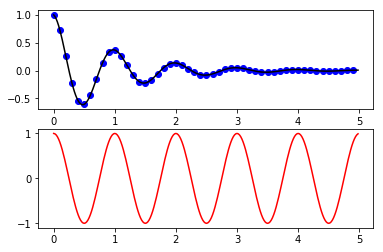

In [26]:


def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)

plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r')

In [16]:
p = 0.4
node0 = create_tree(p)
params = {'root_node':node0,'high_price':8,'low_price':3, 'cost_to_learn':2,'good_art_value':15,'bad_art_value':1,'p':p}

set_payoffs_for_leaf_nodes(**params)
node0.children[0].children[0]

Node('/create_art/high_price/learn', player=3)

In [42]:
high_price = widgets.FloatSlider(min=8,max=20,step=1,value=8)             #low price
low_price = widgets.FloatSlider(min=0,max=8,step=0.5,value=3)             #low price
good_art_value=widgets.FloatSlider(min=10,max=50,step=1,value=20)               #value of good art
bad_art_value=widgets.FloatSlider(min=0,max=10,step=1,value=1)               #value of bad art
cost_to_learn = widgets.FloatSlider(min=0,max=10,step=0.5,value=2)            #cost of learning
player_2 = True

def main(high_price, low_price, cost_to_learn, good_art_value, bad_art_value, player_2):
    player = int(player_2) + 1
    #create tree and payoffs
    node0=create_tree(0)

    behavior1 = []
    behavior2 = []
    behavior3 = []
    behavior4 = []
    behavior5 = []
    behavior6 = []
    p_list = [p for p in range(101)]
    for p in p_list:
        set_payoffs_for_leaf_nodes(node0, high_price, low_price, cost_to_learn, good_art_value, bad_art_value, p)
        node0.children[0].children[0].children[0].prob = p
        node0.children[0].children[0].children[1].prob = 1-p
        node0.children[1].children[0].children[0].prob = p
        node0.children[1].children[0].children[1].prob = 1-p
        behavior1.append(exp(node0.children[0].children[0])[player])
        behavior2.append(exp(node0.children[0].children[1].children[0])[player])
        behavior3.append(exp(node0.children[0].children[1].children[1])[player])
        behavior4.append(exp(node0.children[1].children[0])[player])
        behavior5.append(exp(node0.children[1].children[1].children[0])[player])
        behavior6.append(exp(node0.children[1].children[1].children[1])[player])

    plt.figure(1)
    plt.subplot(211)
    plt.plot(behavior1, p_list, color='red', linewidth=3)
    plt.plot(behavior2, p_list, color='blue', linewidth=3)
    plt.plot(behavior3, p_list, color='green', linewidth=3)
    plt.xlim(-.05, 1.05)
    plt.subplot(212)
    plt.plot(behavior4, p_list, color='red', linewidth=3)
    plt.plot(behavior5, p_list, color='blue', linewidth=3)
    plt.plot(behavior6, p_list, color='green', linewidth=3)
    plt.xlim(-.05, 1.05)
    plt.show()
interact(main, high_price=high_price, \
         low_price=low_price, cost_to_learn=cost_to_learn, good_art_value=good_art_value, \
         bad_art_value=bad_art_value,player_2=player_2)

interactive(children=(FloatSlider(value=8.0, description='high_price', max=20.0, min=8.0, step=1.0), FloatSlider(value=3.0, description='low_price', max=8.0, step=0.5), FloatSlider(value=2.0, description='cost_to_learn', max=10.0, step=0.5), FloatSlider(value=20.0, description='good_art_value', max=50.0, min=10.0, step=1.0), FloatSlider(value=1.0, description='bad_art_value', max=10.0, step=1.0), Checkbox(value=True, description='player_2'), Output()), _dom_classes=('widget-interact',))

<function __main__.main>

################
TESTING:

In [304]:
node0 = create_tree(0.4)

In [291]:
###### TEST FOR set_payoffs_for_leaf_nodes() ######
###### OUTPUT: (8,5) (0,-2) (8, -9) (0,-2) (8,-1.4) (0,0) (3,10) (0,-2) (3, -4) (0,-2) (3,3.6) (0,0) ######
set_payoffs_for_leaf_nodes(node0, 8, 3, 2, 15, 1, 0.4)
[node for node in anytree.iterators.preorderiter.PreOrderIter(node0) if node.is_leaf]

[Node('/create_art/high_price/learn/good_art/buy', payoff={1: 8, 2: 5}, player=2),
 Node('/create_art/high_price/learn/good_art/not_buy', payoff={1: 0, 2: -2}, player=2),
 Node('/create_art/high_price/learn/bad_art/buy', payoff={1: 8, 2: -9}, player=2),
 Node('/create_art/high_price/learn/bad_art/not_buy', payoff={1: 0, 2: -2}, player=2),
 Node('/create_art/high_price/guess/buy', payoff={1: 8, 2: -1.4}, player=2),
 Node('/create_art/high_price/guess/not_buy', payoff={1: 0, 2: 0}, player=2),
 Node('/create_art/low_price/learn/good_art/buy', payoff={1: 3, 2: 10}, player=2),
 Node('/create_art/low_price/learn/good_art/not_buy', payoff={1: 0, 2: -2}, player=2),
 Node('/create_art/low_price/learn/bad_art/buy', payoff={1: 3, 2: -4}, player=2),
 Node('/create_art/low_price/learn/bad_art/not_buy', payoff={1: 0, 2: -2}, player=2),
 Node('/create_art/low_price/guess/buy', payoff={1: 3, 2: 3.6}, player=2),
 Node('/create_art/low_price/guess/not_buy', payoff={1: 0, 2: 0}, player=2)]

In [292]:
###### TEST FOR exp() ########
###### OUTPUT: {1: 3.2, 2: 0.8} #########
exp(node0.children[0].children[0])

{1: 3.2, 2: 0.8}

In [293]:
###### TEST FOR solve() ########
###### OUTPUT: either {1: 8, 2: 5} or {1: 0, 2: -2} #########
solve(node0.children[0].children[0])

Node('/create_art/high_price/learn/bad_art/not_buy', payoff={1: 0, 2: -2}, player=2)

In [294]:
print(RenderTree(node0))

Node('/create_art', player=1)
├── Node('/create_art/high_price', player=2)
│   ├── Node('/create_art/high_price/learn', player=3)
│   │   ├── Node('/create_art/high_price/learn/good_art', player=2, prob=0.4)
│   │   │   ├── Node('/create_art/high_price/learn/good_art/buy', payoff={1: 8, 2: 5}, player=2)
│   │   │   └── Node('/create_art/high_price/learn/good_art/not_buy', payoff={1: 0, 2: -2}, player=2)
│   │   └── Node('/create_art/high_price/learn/bad_art', player=2, prob=0.6)
│   │       ├── Node('/create_art/high_price/learn/bad_art/buy', payoff={1: 8, 2: -9}, player=2)
│   │       └── Node('/create_art/high_price/learn/bad_art/not_buy', payoff={1: 0, 2: -2}, player=2)
│   └── Node('/create_art/high_price/guess', player=2)
│       ├── Node('/create_art/high_price/guess/buy', payoff={1: 8, 2: -1.4}, player=2)
│       └── Node('/create_art/high_price/guess/not_buy', payoff={1: 0, 2: 0}, player=2)
└── Node('/create_art/low_price', player=2)
    ├── Node('/create_art/low_price/learn', 

END OF TESTING
###################

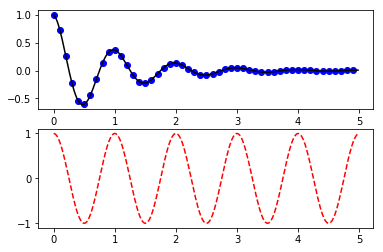